In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch


import torchvision
from torchvision import datasets, transforms
from torch.nn.parameter import Parameter
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.optim import SGD
import sys
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.models as models
from torch.autograd import Variable

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score
from google.colab import files
import copy
from google.colab import drive
import time
import json
import numpy as np
from collections import OrderedDict
import csv
import glob
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
path_to_training_text_embedding = 'drive/MyDrive/deepweeds_data_zsl/text_embeddings/deepweeds_text_embeddings_train.csv'
path_to_training_image_embedding = 'drive/MyDrive/deepweeds_data_zsl/image_embeddings/deepweeds_image_embeddings_train.csv'
path_to_groundtruth = 'drive/MyDrive/deepweeds_data_zsl/ground_truth_text_embeddings.csv'

## get ground truth semantic labels

In [3]:
text_embed_array = np.genfromtxt(path_to_training_text_embedding, delimiter=',')
image_embed_array = np.genfromtxt(path_to_training_image_embedding, delimiter=',')
train_labels = np.genfromtxt('drive/MyDrive/deepweeds_data_zsl/labels/deepweeds_labels_train.csv', delimiter=',')
groundtruth_labels = np.genfromtxt(path_to_groundtruth, delimiter=',')
test_image_embeddings = np.genfromtxt("drive/MyDrive/deepweeds_data_zsl/image_embeddings/deepweeds_image_embeddings_test.csv", delimiter=",")
test_labels = np.genfromtxt("drive/MyDrive/deepweeds_data_zsl/labels/deepweeds_labels_test.csv", delimiter=",")

In [4]:
print(test_image_embeddings.shape)
print(test_labels.shape)


groundtruth_labels = groundtruth_labels[:6]

(3355, 2048)
(3355,)


In [5]:
# remove unseen classes from the set
loc = list(np.where(test_labels == 4)[0]) + list(np.where(test_labels == 5)[0])

test_labels = np.delete(test_labels, loc, axis=0)
test_image_embeddings = np.delete(test_image_embeddings, loc, axis=0)


In [6]:
test_labels = np.where(test_labels == 6,4, test_labels)
test_labels = np.where(test_labels == 7,5, test_labels)



In [7]:
input_dim = 2048
output_dim = 50
tensor_y = torch.Tensor((text_embed_array))
tensor_x = torch.Tensor(image_embed_array)

## AutoEncoder

In [8]:
class Autoencoder(nn.Module):
    def __init__(self,input_size,out_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(), 
            nn.Linear(512, 256), 
            nn.ReLU(), 
            nn.Linear(256,128),
            nn.ReLU(), 
            nn.Linear(128,64),
            nn.ReLU(), 
            nn.Linear(64,32),
            nn.ReLU(), 
            nn.Linear(32,16))
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, out_size))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



class FeedForward(nn.Module):
    def __init__(self,input_size,out_size):
        super(FeedForward, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,1600),
            nn.ReLU(),
            nn.Linear(1600,1000),
            nn.ReLU(), 
            nn.Linear(1000, 600), 
            nn.ReLU(), 
            nn.Linear(600,350),
            nn.ReLU(), 
            nn.Linear(350,120),
            nn.ReLU(), 
            nn.Linear(120,70),
            nn.ReLU(), 
            nn.Linear(70,out_size))

    def forward(self, x):
        x = self.encoder(x)
        return x


class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [9]:
from tqdm import trange
from tqdm import tqdm

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
autoencoder = Autoencoder(input_dim,output_dim)
ff_net = FeedForward(input_dim,output_dim)
# send model to GPU
if torch.cuda.is_available():
    autoencoder.cuda()
    ff_net.cuda()

criterion = nn.MSELoss()

#Testing

In [11]:
print(np.unique(test_labels))

[0. 1. 2. 3. 4. 5.]


In [12]:
criterion = nn.MSELoss()
model_to_test = Autoencoder(input_dim, output_dim)
model_to_test.load_state_dict(torch.load('drive/MyDrive/trained_models/ae_100_epochs'))

if torch.cuda.is_available():
    model_to_test.cuda()
    
model_to_test.eval()



ae_predicted_labels = np.zeros((len(test_image_embeddings),output_dim))
model_to_test.eval()
err = 0
with torch.no_grad():
  for i in range(len(test_image_embeddings)):

    input = (torch.Tensor(test_image_embeddings[i])).to(device)
    output = model_to_test(input)
    true = (torch.Tensor(groundtruth_labels[int(test_labels[i])])).to(device)
    loss = criterion(output, true).cpu().data.numpy()
    pred = np.asarray(output.cpu().data.numpy())
    ae_predicted_labels[i,:] = pred
    
    err += loss
  
print('Average testing MSE for the Autoencoder model:',err/len(test_image_embeddings))
#0.001692089332007746

Average testing MSE for the Autoencoder model: 0.0003229100307054738


## Classifying unseen classes

In [13]:
from sklearn.decomposition import PCA
dims= 50
reducer = PCA(n_components=dims)
reduced_known_labels = reducer.fit_transform(text_embed_array)

reduced_predicted_labels = reducer.transform(ae_predicted_labels)

reduced_groundtruth_labels = reducer.transform(groundtruth_labels)


In [14]:
class_names = ['Chinee Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Siam Weed', 'Snake Weed', 'Prickly Acacia', 'Rubber Vine']


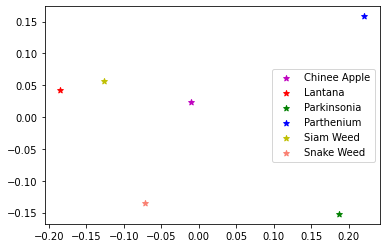

In [15]:
for i in range(len(groundtruth_labels)):
  if i == 0:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'm', marker = '*', label = class_names[i])
  elif i == 1:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'r', marker = '*', label = class_names[i])
  elif i == 2:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'g', marker = '*', label = class_names[i])
  elif i == 3:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'b', marker = '*', label = class_names[i])
  elif i == 4:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'y', marker = '*', label = class_names[i])
  elif i == 5:
    plt.scatter(reduced_groundtruth_labels[:,0][i], reduced_groundtruth_labels[:,1][i], c = 'salmon', marker = '*', label = class_names[i])

plt.legend()

plt.savefig('gt_as_centroids.png')
plt.show()


In [18]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, accuracy_score
label_vals = np.linspace(0,reduced_groundtruth_labels.shape[0] - 1,reduced_groundtruth_labels.shape[0])
dimensions = np.linspace(2,50,49)
accuracies = []
params = []

# SEARCH FOR BEST PERFORMING MODEL

for j in dimensions:
  reducer = PCA(n_components=int(j))
  reduced_known_labels = reducer.fit_transform(text_embed_array)

  reduced_predicted_labels = reducer.transform(ae_predicted_labels)

  reduced_groundtruth_labels = reducer.transform(groundtruth_labels)

  
  for n in np.linspace(1,reduced_groundtruth_labels.shape[0] - 1,reduced_groundtruth_labels.shape[0] - 1):    

    label_prop_model = LabelPropagation(kernel='knn', gamma = int(n), n_neighbors = int(n))
    label_prop_model.fit(reduced_groundtruth_labels, label_vals)
    lp_predictions = label_prop_model.predict(reduced_predicted_labels)
    acc = (accuracy_score(test_labels,lp_predictions))
    accuracies.append(acc)
    params.append(list([j,n]))

  label_prop_model = LabelPropagation(kernel='knn', n_neighbors = 1)
  label_prop_model.fit(reduced_groundtruth_labels, label_vals)
  lp_predictions = label_prop_model.predict(reduced_predicted_labels)
  acc = (accuracy_score(test_labels,lp_predictions))
  accuracies.append(acc)
  params.append(list([j,n]))


# RETURN RESULTS OF BEST PERFORMING MODEL
print('Maximum accuracy of {} when d= {} and n= {}'.format(max(accuracies), params[int(np.argmax(accuracies))][0], params[int(np.argmax(accuracies))][1]))
reducer = PCA(n_components=int(params[int(np.argmax(accuracies))][0]))
reduced_known_labels = reducer.fit_transform(text_embed_array)
reduced_predicted_labels = reducer.transform(ae_predicted_labels)
reduced_groundtruth_labels = reducer.transform(groundtruth_labels)
      
label_prop_model = LabelPropagation(kernel='knn', n_neighbors = int(params[int(np.argmax(accuracies))][1]))
label_prop_model.fit(reduced_groundtruth_labels, label_vals)
lp_predictions = label_prop_model.predict(reduced_predicted_labels)
print(classification_report(test_labels,lp_predictions, target_names= class_names[:6]))

      

Maximum accuracy of 0.7713607594936709 when d= 5.0 and n= 1.0
              precision    recall  f1-score   support

Chinee Apple       0.59      0.56      0.57       225
     Lantana       0.86      0.82      0.84       212
 Parkinsonia       0.97      0.94      0.95       206
  Parthenium       0.87      0.88      0.88       204
   Siam Weed       0.87      0.94      0.90       214
  Snake Weed       0.49      0.49      0.49       203

    accuracy                           0.77      1264
   macro avg       0.77      0.77      0.77      1264
weighted avg       0.77      0.77      0.77      1264



In [ ]:
# NearestCentroid clustering

def NearestCentroid(projections,centroids):
  'computes the distance of every point to a centroid'
  preds = []
  for point in projections:
    distances = [np.linalg.norm(point-gt) for gt in centroids]
    preds.append(np.argmin(distances))
  return preds


dims= np.linspace(2,50,49)
a = []
for d in dims:

  reducer = PCA(n_components=int(d))
  reduced_known_labels = reducer.fit_transform(text_embed_array)

  reduced_predicted_labels = reducer.transform(ae_predicted_labels)

  reduced_groundtruth_labels = reducer.transform(groundtruth_labels)

  nc_predictions = NearestCentroid(reduced_predicted_labels,reduced_groundtruth_labels)
  acc= accuracy_score(test_labels,nc_predictions)
  #print(classification_report(test_labels,nc_predictions, target_names= class_names))
  print('Accuracy for a NC classifier in {} dimensions: '.format(int(d)), acc)
  a.append(acc)
#print(classification_report(test_labels,nc_predictions, target_names= class_names))

In [ ]:
plt.plot(dims, a, label = 'NC accuracy')
plt.plot(dims, accuracies, label = 'LPA accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.xlabel('Dimension')
plt.savefig('perf_nearestcentroid.png')
plt.show()
print(dimensions)